Generate 112 trials (for now 1 only subject)

trials with shock after n seconds change physio signals
trials w\out shock no change in physio

In [3]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns

In [7]:
TRIAL_LEN = 6
SHOCK_TIME = 4

assert SHOCK_TIME <= TRIAL_LEN

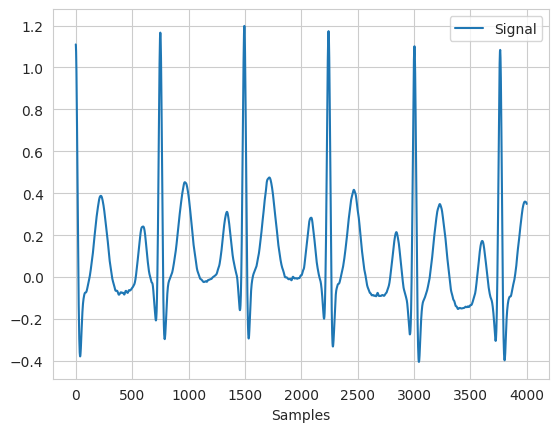

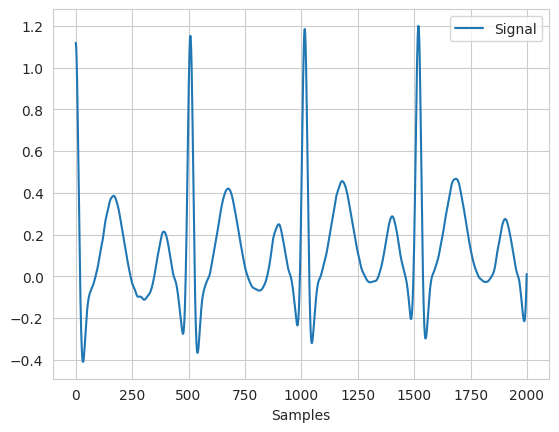

In [19]:
# Alternate heart rate and noise levels
ecg_low = nk.ecg_simulate(duration=SHOCK_TIME, noise=0.01, heart_rate=80)
ecg_high = nk.ecg_simulate(duration=TRIAL_LEN-SHOCK_TIME, noise=0.01, heart_rate=120)

# Visualize
#ecg_df = pd.DataFrame({"ECG_120": ecg120, "ECG_80": ecg80})

nk.signal_plot(ecg_low)
nk.signal_plot(ecg_high)

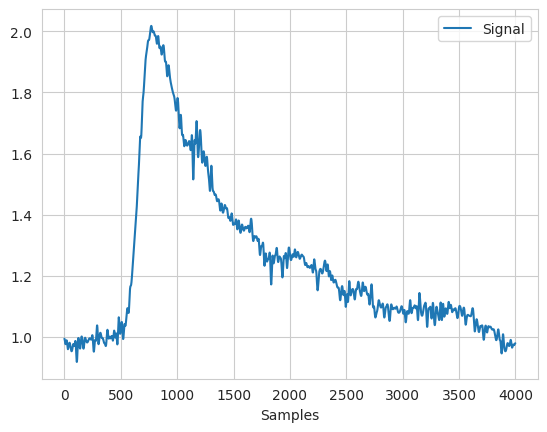

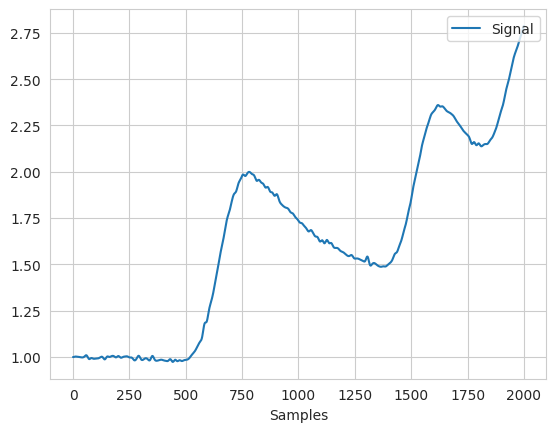

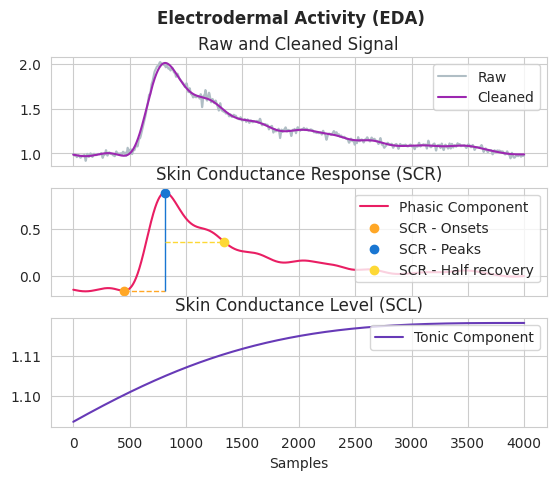

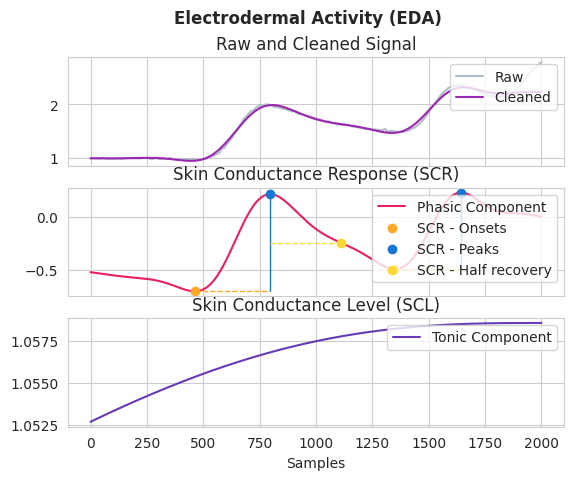

In [17]:
# Simulate
eda_low = nk.eda_simulate(duration=SHOCK_TIME, scr_number=1, drift=-0.01, noise=0.05)
eda_high = nk.eda_simulate(duration=TRIAL_LEN-SHOCK_TIME, scr_number=3, drift=-0.01, noise=0.01)


# Visualize
nk.signal_plot(eda_low)
nk.signal_plot(eda_high)

signals, info = nk.eda_process(eda_low, sampling_rate=1000)
nk.eda_plot(signals)


signals_, info_ = nk.eda_process(eda_high, sampling_rate=1000)
nk.eda_plot(signals_)